In [1]:
import torch
import numpy as np
from rpc import RPCModelParameterTorch
import os
import cv2
from utils import project_mercator
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

In [2]:
def bilinear_interpolate(array, points):
    """
    输入：
    - array: 二维 (H, W) 或三维 (H, W, C) 的数组
    - points: (N, 2) 的浮点坐标数组，每行表示一个坐标 [x, y]
    输出：
    - 插值结果，形状为 (N,) 或 (N, C)
    """
    array = np.asarray(array)
    points = np.asarray(points)
    
    # 将二维数组扩展为 (H, W, 1) 以统一处理
    if array.ndim == 2:
        array = array[..., np.newaxis]
    
    H, W, C = array.shape
    x = points[:, 0].astype(float)
    y = points[:, 1].astype(float)
    
    # 计算整数坐标并约束边界
    x0 = np.floor(x).astype(int)
    x1 = np.clip(x0 + 1, 0, W-1)
    x0 = np.clip(x0, 0, W-1)
    
    y0 = np.floor(y).astype(int)
    y1 = np.clip(y0 + 1, 0, H-1)
    y0 = np.clip(y0, 0, H-1)
    
    # 提取四个角点的值，形状 (N, C)
    Ia = array[y0, x0, :]
    Ib = array[y1, x0, :]
    Ic = array[y0, x1, :]
    Id = array[y1, x1, :]
    
    # 计算权重
    dx = x - x0
    dy = y - y0
    wa = (1 - dx) * (1 - dy)
    wb = (1 - dx) * dy
    wc = dx * (1 - dy)
    wd = dx * dy
    
    # 加权求和（广播到所有通道）
    result = (
        wa[:, None] * Ia +
        wb[:, None] * Ib +
        wc[:, None] * Ic +
        wd[:, None] * Id
    )
    
    # 压缩多余的维度（若原始输入是二维）
    if array.shape[-1] == 1 and array.ndim == 3:
        result = result.squeeze(axis=1)
    
    return result

def dis2color(dis):
    div = 6.
    if dis > div:
        return (255,0,0)
    else:
        return (0,255,0)

In [117]:
res_root = './res_valid'
dataset_root = './datasets/WV_1024_valid'
res_files = os.listdir(res_root)
bar = tqdm(res_files)
for res_file in bar:
    d = int(res_file.split('_')[0][-1])
    v1 = int(res_file.split('_')[1][-1])
    v2 = int(res_file.split('_')[2][-1])
    img_name = res_file.split('_')[3].split('.')[0]
    bar.set_postfix({'dataset':d,'v1':v1,'v2':v2,'img':img_name})
    img1 = cv2.imread(f'{dataset_root}/d{d}_v{v1}/{img_name}.png',cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(f'{dataset_root}/d{d}_v{v2}/{img_name}.png',cv2.IMREAD_GRAYSCALE)
    local1 = np.load(f'{dataset_root}/d{d}_v{v1}/{img_name}_local.npy')
    local2 = np.load(f'{dataset_root}/d{d}_v{v2}/{img_name}_local.npy')
    dem1 = np.load(f'{dataset_root}/d{d}_v{v1}/{img_name}_dem.npy')
    dem2 = np.load(f'{dataset_root}/d{d}_v{v2}/{img_name}_dem.npy')
    rpc1 = RPCModelParameterTorch()
    rpc2 = RPCModelParameterTorch()
    rpc1.load_from_file(f'{dataset_root}/d{d}_v{v1}/d{d}_v{v1}.rpc')
    rpc2.load_from_file(f'{dataset_root}/d{d}_v{v2}/d{d}_v{v2}.rpc')
    rpc1.to_gpu()
    rpc2.to_gpu()
    if os.path.exists(f'{dataset_root}/d{d}_v{v1}/{img_name}_res.npy'):
        res1 = np.load(f'{dataset_root}/d{d}_v{v1}/{img_name}_res.npy')
    else:
        res1 = np.full(img1.shape[:2],np.nan)
    if os.path.exists(f'{dataset_root}/d{d}_v{v2}/{img_name}_res.npy'):
        res2 = np.load(f'{dataset_root}/d{d}_v{v2}/{img_name}_res.npy')
    else:
        res2 = np.full(img2.shape[:2],np.nan)

    with open(os.path.join(res_root,res_file),'r') as f:
        data = f.readlines()
    kpts1 = np.array([[float(j) for j in i.split()][:2] for i in data]) # line,samp
    kpts2 = np.array([[float(j) for j in i.split()][-2:] for i in data])
    height1 = bilinear_interpolate(dem1,kpts1)
    height2 = bilinear_interpolate(dem2,kpts2)
    local1 = bilinear_interpolate(local1,kpts1)
    local2 = bilinear_interpolate(local2,kpts2)
    
    geo1 = torch.stack(rpc1.RPC_PHOTO2OBJ(local1[:,1],local1[:,0],height1),dim=1)
    geo2 = torch.stack(rpc2.RPC_PHOTO2OBJ(local2[:,1],local2[:,0],height2),dim=1)
    proj1 = project_mercator(geo1)
    proj2 = project_mercator(geo2)
    dis = torch.norm(proj1 - proj2,dim=1).cpu().numpy()
    res1[np.round(kpts1[:,0]).astype(int),np.round(kpts1[:,1]).astype(int)] = np.fmax(res1[np.round(kpts1[:,0]).astype(int),np.round(kpts1[:,1]).astype(int)],dis)
    res2[np.round(kpts2[:,0]).astype(int),np.round(kpts2[:,1]).astype(int)] = np.fmax(res2[np.round(kpts2[:,0]).astype(int),np.round(kpts2[:,1]).astype(int)],dis)
    # print(res1,np.nanmax(res1),np.nanmin(res1),np.nanmean(res1),np.nanmedian(res1))
    np.save(f'{dataset_root}/d{d}_v{v1}/{img_name}_res.npy',res1.astype(np.float32))
    np.save(f'{dataset_root}/d{d}_v{v2}/{img_name}_res.npy',res2.astype(np.float32))
    # print(dis,np.mean(dis),np.median(dis))
    # plt.hist(dis,100)
    # pic = np.zeros((img1.shape[0],img1.shape[1]+img2.shape[1],3),dtype=np.uint8)
    # pic[:,:img1.shape[0],:] = np.stack([img1]*3,-1)
    # pic[:,-img2.shape[0]:,:] = np.stack([img2]*3,-1)
    # for i in range(len(kpts1)):
    #     color = dis2color(dis[i])
    #     cv2.circle(pic,(np.round(kpts1[i,1]).astype(int),np.round(kpts1[i,0]).astype(int)),1,color,-1)
    #     cv2.circle(pic,(np.round(kpts2[i,1]).astype(int) + img1.shape[1],np.round(kpts2[i,0]).astype(int)),1,color,-1)
    # Image.fromarray(pic).show()
    

100%|██████████| 834/834 [01:24<00:00,  9.83it/s, dataset=5, v1=1, v2=2, img=9] 


/tmp/ipykernel_2415957/2831764986.py:29: RuntimeWarning: Mean of empty slice
  output = np.nanmean(reshaped,axis=(1,3))


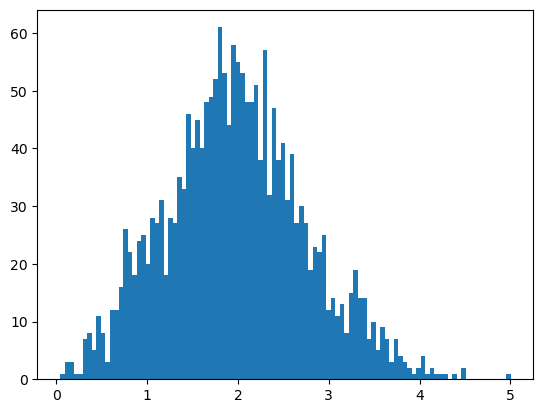

In [114]:
def sliding_window_average(arr, a):
    """
    对输入数组进行滑动窗口平均处理，窗口和步长均为a
    参数：
        arr : 输入数组，形状为(H, W)或(H, W, C)
        a : 窗口和步长大小
        pad_mode : 填充模式，默认用边缘值填充
    返回：
        平均后的数组，形状为(ceil(H/a), ceil(W/a), C)或(ceil(H/a), ceil(W/a))
    """
    # 处理二维输入
    is_2d = arr.ndim == 2
    if is_2d:
        arr = arr[..., np.newaxis]
    
    H, W, C = arr.shape
    
    # 计算填充后的尺寸
    new_H = ((H + a - 1) // a) * a
    new_W = ((W + a - 1) // a) * a
    
    # 边缘填充
    padded = np.pad(arr, ((0, new_H - H), (0, new_W - W), (0, 0)),constant_values=np.nan)
    
    # 重塑为四维块数组(H//a, a, W//a, a, C)
    reshaped = padded.reshape(new_H//a, a, new_W//a, a, C)
    
    # 对窗口内的所有元素求均值
    output = np.nanmean(reshaped,axis=(1,3))
    
    # 恢复二维输出
    if is_2d:
        output = output.squeeze(axis=-1)
    
    return output
name = './datasets/WV_1024/d2_v0/9' #132
res1 = np.load(f'{name}_res.npy')
img = cv2.imread(f'{name}.png')
res1_ds = sliding_window_average(res1,16)
# plt.imshow(res1_ds)
idxs = np.stack(np.where(~np.isnan(res1_ds)),axis=-1)
plt.hist(res1_ds[idxs[:,0],idxs[:,1]],100)
for idx in idxs:
    color = dis2color(res1_ds[int(idx[0]),int(idx[1])])
    cv2.circle(img,(int((idx[1]+.5)*16),int((idx[0]+.5)*16)),1,color,-1)
Image.fromarray(img).show()
